In [28]:
import pandas as pd 
import numpy as np 
import sys
import config
import os
from sklearn.cluster import KMeans

In [4]:
sys.path.append("../scripts/")

In [6]:
from feature_creation import * 

In [7]:
df = pd.read_csv(config.TRAINING_DATA_PATH)

In [8]:
model = 'adhoc'
fold = 0

if not os.path.exists(f'../resources/{model}'):
        os.makedirs(f'../resources/{model}')

feature_pipeline = Pipeline(steps=[
                ("Language Features",LanguageFeature()),
                ("Graph Features",GraphFeatures()),
                ("Node Features",NodeFeatures()),
                ("Dataset Creation",FormatDataFrame()),
                ("Language One Hot Encoding",LanguageOHE(enc_lan=f"{model}/lan_encoder_{model}_{fold}.pkl",\
                                                         enc_lan_family=f"{model}/lan_family_encoder_{model}_{fold}.pkl"))  
            ])

In [9]:
data = feature_pipeline.fit_transform(df)

Langauge Feature Started
Langauge Feature Ended
Graph Features Creation Started
Graph Feature Creation Ended
Node Features Creation Started
Node Features Creation Ended
DataFrame Creation Started
DataFrame Creation Ended!!
One Hot Encoding Started
One Hot Encoding created and Saved


In [33]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [13]:
x_data = data.drop(columns=['is_root','language','language_group','sentence'])

In [14]:
x_scaled = StandardScaler().fit_transform(x_data)

In [ ]:
pca = PCA()
pca.fit(x_scaled)

# Cumulative variance explained
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

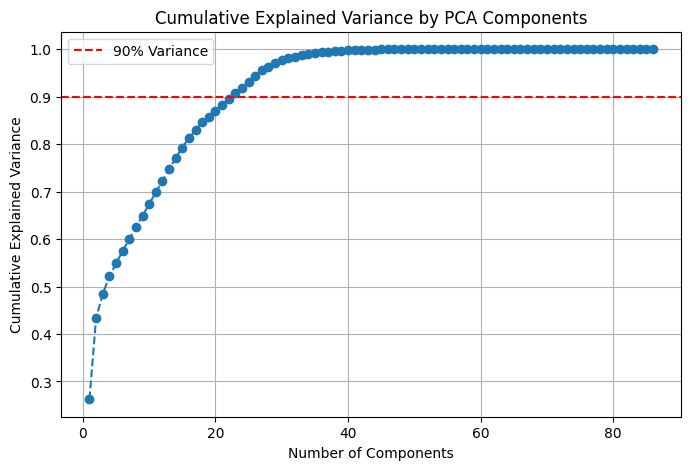

In [35]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance')  # Optional: mark 90% threshold
plt.legend()
plt.show()

In [36]:
for threshold in [0.90, 0.95, 0.99]:
    num_components = np.argmax(cumulative_variance >= threshold) + 1
    print(f"To retain {int(threshold*100)}% variance, you need {num_components} components.")

To retain 90% variance, you need 23 components.
To retain 95% variance, you need 27 components.
To retain 99% variance, you need 35 components.


In [38]:
pca = PCA(n_components=35)
x_pca = pca.fit_transform(x_scaled)


In [39]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
x_tsne = tsne.fit_transform(x_pca)

/Users/nishantsushmakar/Documents/UPC/UPC-ML-Challenge/venv/lib/python3.13/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [40]:
y = data.is_root

In [41]:
labels = ['not_root','root']

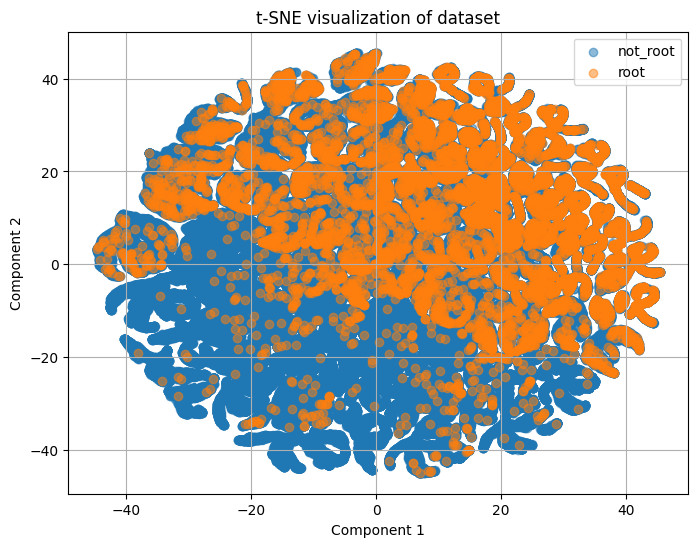

In [42]:
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(y)):
    plt.scatter(x_tsne[y == i, 0], x_tsne[y == i, 1], label=labels[i],alpha=0.5)
plt.title("t-SNE visualization of dataset")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True)
plt.show()

In [43]:
cluster_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(x_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(x_scaled, labels))


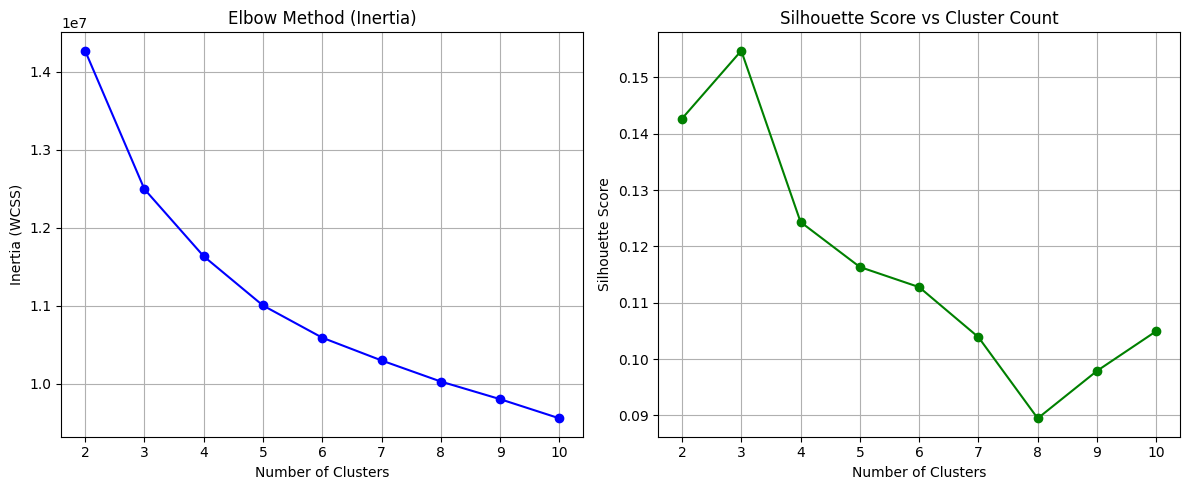

In [44]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertias, 'o-', color='blue')
plt.title('Elbow Method (Inertia)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (WCSS)')
plt.grid(True)

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, 'o-', color='green')
plt.title('Silhouette Score vs Cluster Count')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()


In [74]:
selected_k = 3
kmeans = KMeans(n_clusters=selected_k, random_state=42, n_init=10)


In [75]:
labels = kmeans.fit_predict(x_scaled)

In [76]:
data['cluster_labels'] = labels

In [77]:
data[['is_root','cluster_labels']].corr()

,is_root,cluster_labels
is_root,1.000000,-0.152382
cluster_labels,-0.152382,1.000000


In [78]:
data.groupby('cluster_labels')['is_root'].mean()

cluster_labels
0    0.122874
1    0.005621
2    0.039013
Name: is_root, dtype: float64

In [ ]:
data